In [1]:
from sleep_analysis.datasets.d04_main_dataset import D04MainStudy
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing

In [32]:
from sleep_analysis.preprocessing.d04_main.movement import preprocess_movement_df, preprocess_movement, _threshold, _normalize

In [3]:
from empkins_io.sync import SyncedDataset

import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [4]:
from biopsykit.signals.ecg import EcgProcessor

In [5]:
from empkins_micro.emrad.radar import get_rpeaks, get_peak_probabilities

In [6]:
from fau_colors import cmaps, register_fausans_font

In [7]:
%matplotlib widget

In [8]:
register_fausans_font()
plt.close("all")

palette = sns.color_palette(cmaps.faculties)
sns.set_theme(context="notebook", style="ticks", font="sans-serif", palette=palette)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.default"] = "regular"

palette

[(0.0, 0.1843137254901961, 0.4235294117647059),
 (0.4666666666666667, 0.6235294117647059, 0.7098039215686275),
 (1.0, 0.7215686274509804, 0.10980392156862745),
 (0.0, 0.6392156862745098, 0.8784313725490196),
 (0.2627450980392157, 0.6901960784313725, 0.16470588235294117),
 (0.7843137254901961, 0.06274509803921569, 0.1803921568627451)]

In [9]:
### General Settings
id = 4

# General Radar Settings
fs_radar = 1953.125

In [10]:
dataset = D04MainStudy()

In [11]:
dataset

,subj_id
0,01
1,02
2,03
3,04
4,05
5,06
6,07
7,08
8,09
9,10


In [12]:
radar_data = dataset[id].radar_data.data_as_df(index='local_datetime', add_sync_out=True)
synced_radar = dataset[id].sync_radar(radar_data)

Prepare SyncedDataset
Sync beginning of m-sequence


/Users/danielkrauss/code/Empkins/empkins-io/empkins_io/sync/_sync.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_secondary.loc[:, sync_channel_secondary] = self._binarize_signal(


-10


/Users/danielkrauss/code/Empkins/empkins-io/empkins_io/sync/_sync.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_secondary.loc[:, sync_channel_secondary] = self._binarize_signal(


32


/Users/danielkrauss/code/Empkins/empkins-io/empkins_io/sync/_sync.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_secondary.loc[:, sync_channel_secondary] = self._binarize_signal(


27
Find shift at the end of the m-sequence
Shift: radar_2_aligned_ 563
Shift: radar_3_aligned_ 243
Shift: radar_4_aligned_ 45
Resample sample-wise to get equal length
shortest:75774917
75774917
75775480
75775160
75774962


In [17]:
df_1 = synced_radar["radar_1_resampled_"]
df_2 = synced_radar["radar_2_resampled_"]
df_3 = synced_radar["radar_3_resampled_"]
df_4 = synced_radar["radar_4_resampled_"]

In [22]:
movement_1 = preprocess_movement_df(df_1)
movement_2 = preprocess_movement_df(df_2)
movement_3 = preprocess_movement_df(df_3)
movement_4 = preprocess_movement_df(df_4)

/Users/danielkrauss/code/Empkins/sleep-analysis/sleep_analysis/preprocessing/d04_main/movement.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'MA'] = padded[window_size // 2:len(padded) - window_size // 2]
/Users/danielkrauss/code/Empkins/sleep-analysis/sleep_analysis/preprocessing/d04_main/movement.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MA'] = df['MA'].rolling(window=window_size, center=True, min_periods=1).mean()
/Users/danielkrauss/code/Empkins/sleep-analysis/sleep_analy

In [26]:
actigraphy = dataset[id].activity_data.data_as_df(index='local_datetime')

actigraphy.index = actigraphy.index.floor("30s")
actigraphy = actigraphy.groupby(pd.Grouper(freq='30s', origin='epoch')).mean()
actigraphy = _threshold(actigraphy, channel="Activity", threshold=0.05)
actigraphy = _normalize(actigraphy, channel="threshold")

Extracting EDF parameters from /Users/danielkrauss/code/Empkins/Data/empkins_contactless_sleep_lab/Vp_05/psg/Vp_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [48]:
# Create dictionary of sub-dataframes
radar_dict = {}
for radar in ['radar_1_resampled_', 'radar_2_resampled_', 'radar_3_resampled_', 'radar_4_resampled_']:
    radar_dict[radar] = synced_radar[radar]

In [50]:
movement_df = preprocess_movement(radar_dict)

In [51]:
movement_df

,movement
date (Europe/Berlin),
2023-04-18 21:27:30+02:00,0.0
2023-04-18 21:28:00+02:00,0.0
2023-04-18 21:28:30+02:00,0.0
2023-04-18 21:29:00+02:00,0.0
2023-04-18 21:29:30+02:00,0.0
...,...
2023-04-19 08:12:00+02:00,0.0
2023-04-19 08:12:30+02:00,0.0
2023-04-19 08:13:00+02:00,0.0


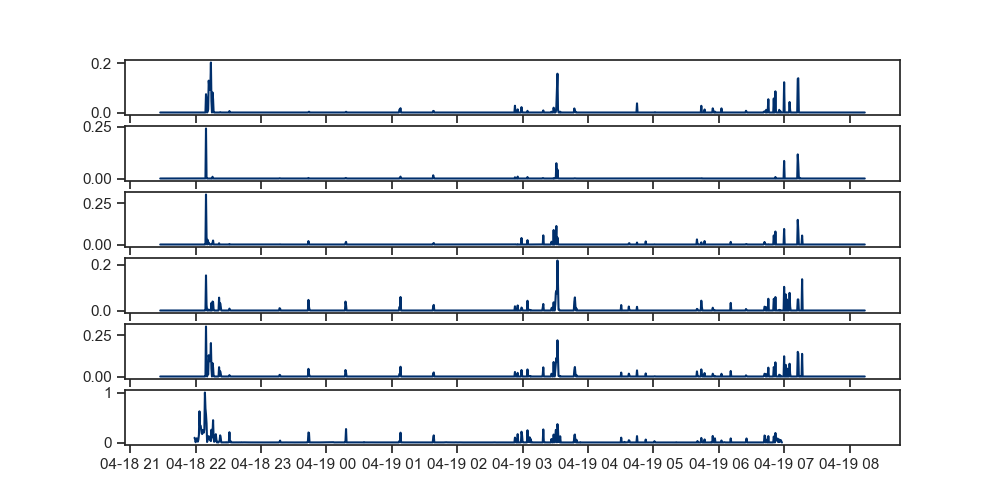

In [52]:
fig, ax = plt.subplots(6, sharex=True)
ax[0].plot(movement_1["grouped"])
ax[1].plot(movement_2["grouped"])
ax[2].plot(movement_3["grouped"])
ax[3].plot(movement_4["grouped"])
ax[4].plot(movement_df["movement"])
ax[5].plot(actigraphy["NORM"])